In [3]:
#Load all the modules used in this file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet

In [14]:
# read in the input table to examine its contents

df = pd.read_csv('./data/Toronto Island Ferry Ticket Counts.csv',
                dtype={'_id':int, 'Redemption Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
df.head()

,_id,Timestamp,Redemption Count,Sales Count
0,1,2025-06-11 19:45:00,77,78
1,2,2025-06-11 19:30:00,93,60
2,3,2025-06-11 19:15:00,81,75
3,4,2025-06-11 19:00:00,89,89
4,5,2025-06-11 18:45:00,613,622


In [15]:
# getting an overview of the values in table
df.describe()

,_id,Timestamp,Redemption Count,Sales Count
count,246838.000000,246838,246838.000000,246838.000000
mean,123419.500000,2020-07-15 20:10:53.365769984,46.898111,47.661053
min,1.000000,2015-05-01 13:30:00,0.000000,0.000000
25%,61710.250000,2018-01-29 12:18:45,3.000000,3.000000
50%,123419.500000,2020-08-15 22:52:30,10.000000,12.000000
75%,185128.750000,2023-01-28 14:41:15,38.000000,46.000000
max,246838.000000,2025-06-11 19:45:00,7216.000000,7229.000000
std,71256.137211,NaN,101.729094,97.594245


In [16]:
# checking if the high values in Redemption and Sales Count are single outliers or part of a long tail in the distribution
df.sort_values(by = ['Redemption Count'], ascending = False).head(50)

,_id,Timestamp,Redemption Count,Sales Count
46924,46925,2023-08-15 20:15:00,7216,7229
42573,42574,2023-10-10 14:00:00,5535,5518
25447,25448,2024-06-19 19:00:00,5341,5342
21511,21512,2024-08-05 22:00:00,4973,4995
18840,18841,2024-09-07 17:00:00,4966,4974
50340,50341,2023-07-05 21:15:00,3602,3634
73188,73189,2022-08-15 10:30:00,3520,3408
74701,74702,2022-07-28 12:00:00,3386,3400
23538,23539,2024-07-12 19:45:00,3066,3143
13988,13989,2024-11-13 16:45:00,2866,2863


11:19:57 - cmdstanpy - INFO - Chain [1] start processing
11:20:56 - cmdstanpy - INFO - Chain [1] done processing


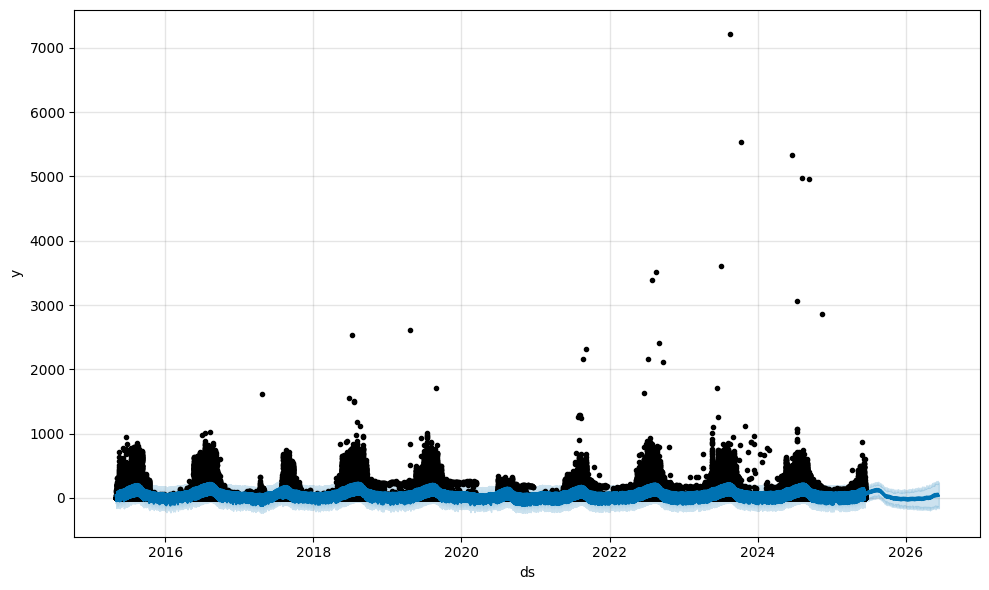

In [18]:
# now creating a new model with Prophet, which can handle multiple cycles in a timeseries.
# It takes a two-column dataframe with specific colnames as input. Creating it and converting to daily format
df_redemption = df[['Timestamp',
                    'Redemption Count']]
df_redemption = df_redemption.rename(mapper = {'Timestamp':'ds',
                               'Redemption Count':'y'},
                     axis = 1)

m = Prophet()
m = m.fit(df_redemption)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)

11:21:46 - cmdstanpy - INFO - Chain [1] start processing
11:22:46 - cmdstanpy - INFO - Chain [1] done processing


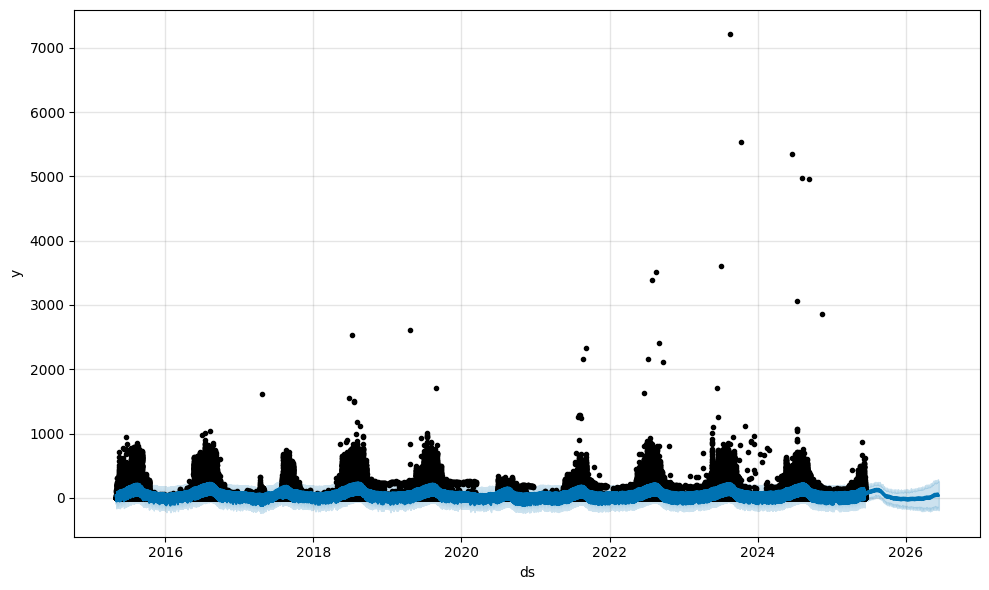

In [19]:
# this model is underfit, but Prophet has a parameter to deal with that. Trying again by setting it
m_05 = Prophet(changepoint_prior_scale = 0.5)
m_05 = m_05.fit(df_redemption)
future_05 = m_05.make_future_dataframe(periods=365)
forecast_05 = m_05.predict(future_05)
fig_05 = m_05.plot(forecast_05)

In [20]:
# not much change again. I'll try removing time of day variability instead to see if it improves the fit
df_daily = df.set_index('Timestamp', inplace=False)
df_daily = df_daily.resample('d').sum()
df_daily = df_daily.reset_index()
df_daily_redemption = df_daily[['Timestamp',
                                'Redemption Count']]
df_daily_redemption = df_daily_redemption.rename(mapper = {'Timestamp':'ds',
                               'Redemption Count':'y'},
                     axis = 1)

11:23:25 - cmdstanpy - INFO - Chain [1] start processing
11:23:26 - cmdstanpy - INFO - Chain [1] done processing


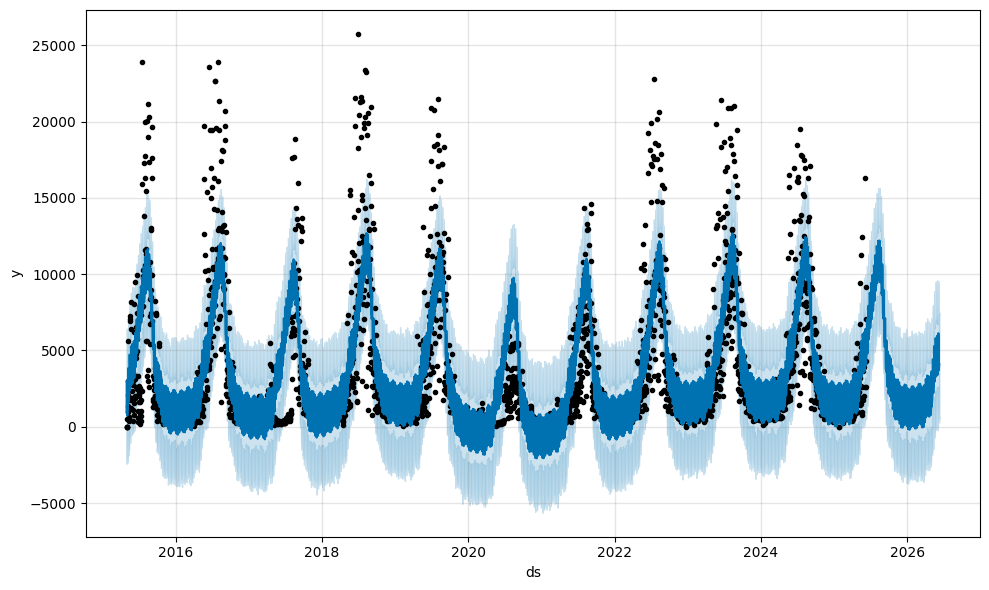

In [21]:
# now trying with each day as one single datapoint
m_005d = Prophet()
m_005d = m_005d.fit(df_daily_redemption)
future_005d = m_005d.make_future_dataframe(periods=365)
forecast_005d = m_005d.predict(future_005d)
fig_005d = m_005d.plot(forecast_005d)

11:23:40 - cmdstanpy - INFO - Chain [1] start processing
11:23:42 - cmdstanpy - INFO - Chain [1] done processing


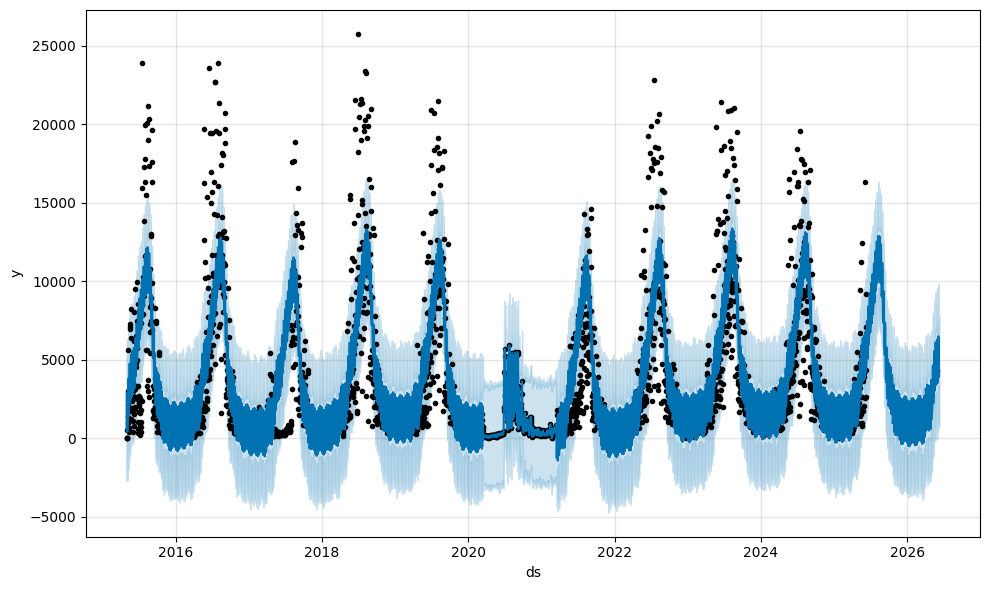

In [22]:
# Much better!
# It seems like there was much less travel during 2020 - the COVID lockdown.
# I'll include this into the model as well. In Ontario the lockdown lasted about a year, from March 2020 - February 2021
event_df = pd.DataFrame({
  'holiday': 'COVID',
  'ds': pd.to_datetime(['2020-03-17']),
  'lower_window': 0,
  'upper_window': 365
})

m2 = Prophet(holidays = event_df)
m2 = m2.fit(df_daily_redemption)
future_m2 = m2.make_future_dataframe(periods=365)
forecast_m2 = m2.predict(future_m2)
fig_m2 = m2.plot(forecast_m2)

In [23]:
# It seems that the vast majority purchases and rides occur from May to October (checked by looking at years one by one)
# According to the Wiki page for Toronto, this is also when the temperature is above 10 degrees Celsius
# Maybe should incorporate annual average daily temperature into the models.... for now, will divide the annual cycles into two

In [24]:
def is_cold(ds):
    date = pd.to_datetime(ds)
    return (date.month > 10 or date.month < 5)

df_daily_redemption['on_season'] = ~df_daily_redemption['ds'].apply(is_cold)
df_daily_redemption['off_season'] = df_daily_redemption['ds'].apply(is_cold)

11:24:06 - cmdstanpy - INFO - Chain [1] start processing
11:24:07 - cmdstanpy - INFO - Chain [1] done processing


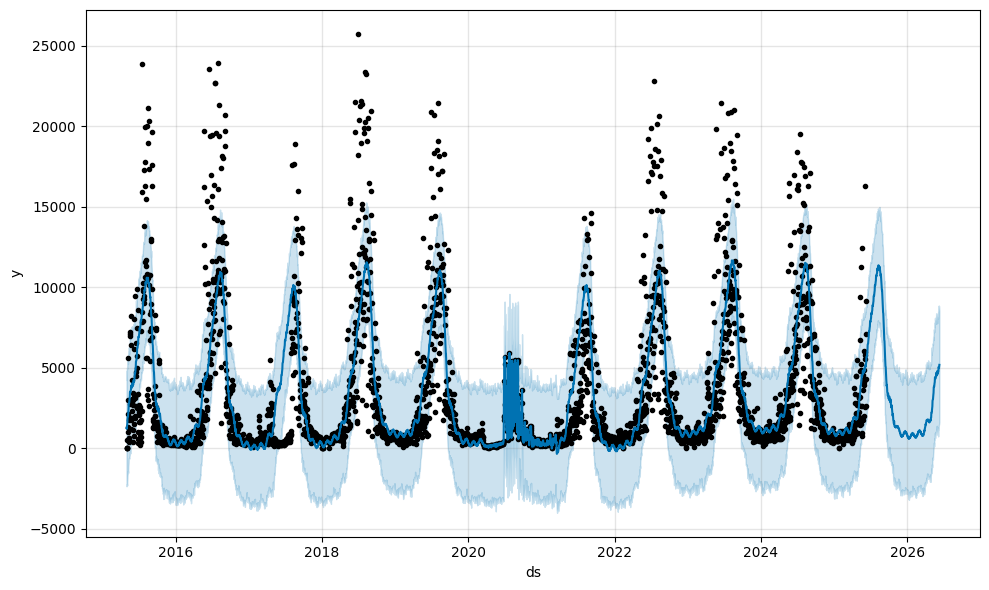

In [25]:
m3 = Prophet(holidays = event_df, weekly_seasonality=False)
m3.add_seasonality(name='weekly_on_season', period=6, fourier_order=3, condition_name='on_season')
m3.add_seasonality(name='weekly_off_season', period=6, fourier_order=3, condition_name='off_season')

m3 = m3.fit(df_daily_redemption)
future_m3 = m3.make_future_dataframe(periods=365)
future_m3['on_season'] = ~future_m3['ds'].apply(is_cold)
future_m3['off_season'] = future_m3['ds'].apply(is_cold)
forecast_m3 = m3.predict(future_m3)
fig_m3 = m3.plot(forecast_m3)

In [4]:
# finally, will try modelling with xgboost
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Redemption Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features
    df_daily['month'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['weekday'] = df_daily.reset_index().Timestamp.dt.weekday.values
    df_daily['day of year'] = df_daily.reset_index().Timestamp.dt.day_of_year.values
    return df_daily

In [5]:
# Loading data
df = load_data('./data/Toronto Island Ferry Ticket Counts.csv')
df.head()

,_id,Redemption Count,Sales Count,month,weekday,day of year
Timestamp,,,,,,
2015-05-01,987346,1,4,5,4,121
2015-05-02,0,0,0,5,5,122
2015-05-03,0,0,0,5,6,123
2015-05-04,4689675,12,75,5,0,124
2015-05-05,11352455,537,549,5,1,125


In [6]:
# Converting all cyclical features to actual cycles with sinus / cosinus transformation

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

df['day_sin'] = np.sin(2 * np.pi * df['day of year'] / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df['day of year'] / 365.25)

# Dropping columns that are no longer needed
df = df.drop(['_id', 'month', 'weekday', 'day of year'], axis=1)

# adding two new columns: pandemic yes/no and summer yes/no

event_df = pd.DataFrame({
        'holiday': 'worst COVID',
        'ds': pd.to_datetime(['2020-03-17']),
        'ds_upper': pd.to_datetime(['2022-03-16'])}) 

df = df.reset_index()
df['is_covid'] = (df['Timestamp'] > pd.to_datetime('2020-03-17')) & (df['Timestamp'] < pd.to_datetime('2022-03-16'))
date_tmp = pd.to_datetime(df['Timestamp'])
df['is_cold'] = (date_tmp.dt.month < 5) | (date_tmp.dt.month > 10)
df = df.set_index('Timestamp')
df['is_cold'] = df['is_cold'].astype('int64')
df['is_covid'] = df['is_covid'].astype('int64')

In [7]:
# selecting and splitting data

X = df[['month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'is_cold', 'is_covid']]
y = df[['Redemption Count']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [8]:
# Defining a wide parameter grid
param_grid = {
    'n_estimators': [60, 80, 100, 120, 140],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0]}

# Model and random search. Assunibg the output to have a tweedie distribution (informative zeroes and a strong tail)
model = xgb.XGBRegressor(objective='reg:tweedie', random_state=17, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 80,
 'max_depth': 3,
 'learning_rate': 0.15,
 'colsample_bytree': 0.8}

In [9]:
model = xgb.XGBRegressor(
    objective='reg:tweedie',
    tweedie_variance_power = 1.2,
    random_state=17,
    **best_params
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [10]:
y_pred = model.predict(X_test)
# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {mse ** 0.5}, MAE: {mae}, R²: {r2}")

RMSE: 2578.879795570162, MAE: 1423.7421875, R²: 0.6825230121612549


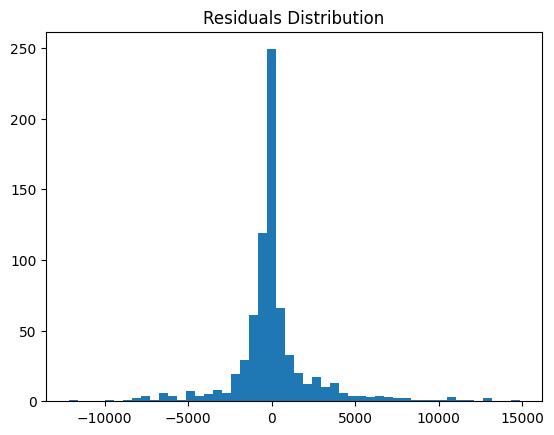

In [12]:
y_test = y_test.values.flatten()
y_pred = y_pred.flatten()  # Only needed if it has extra dimensions
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.show()

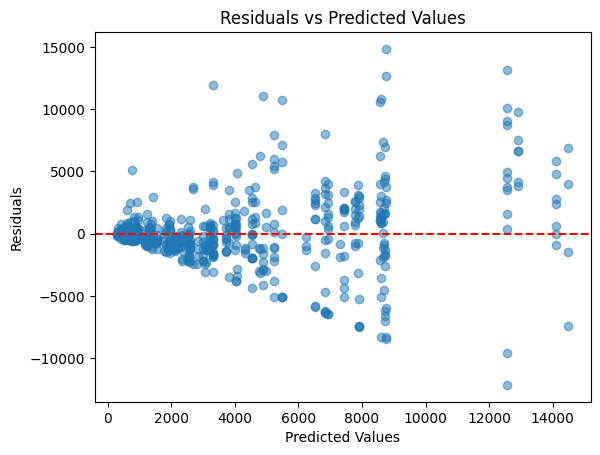

In [13]:
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

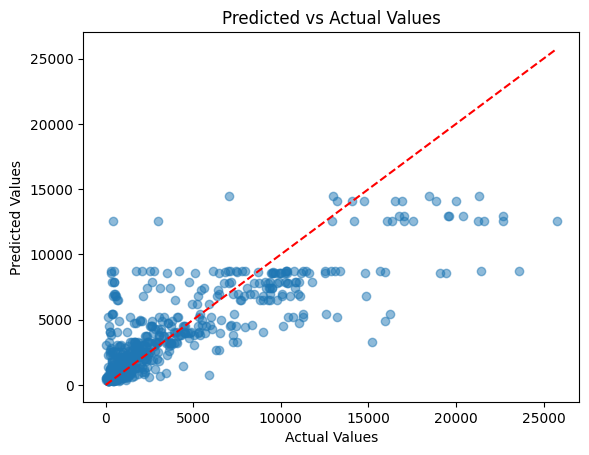

In [14]:
# Scatter plot: Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree line
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

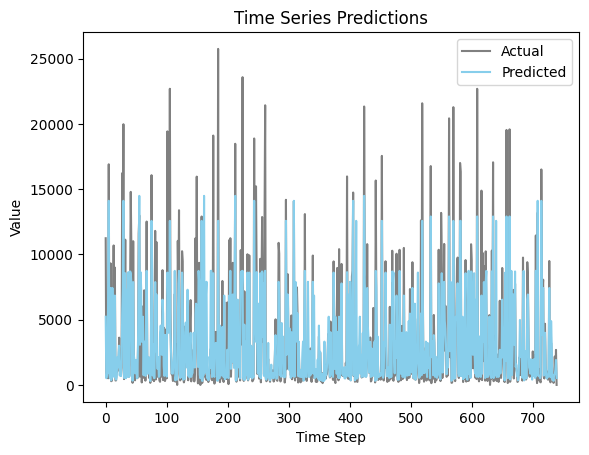

In [15]:
# Create a line plot for time series
plt.plot(range(len(y_test)), y_test, label="Actual", color='grey')
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color='skyblue')
plt.title("Time Series Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

In [17]:
res = pd.DataFrame({'Date' : X_test.index, 'Predicted' : y_pred})
res.sort_values(by = 'Date')

,Date,Predicted
629,2015-05-01,3073.440430
730,2015-05-08,3073.440430
192,2015-05-13,2548.303223
56,2015-05-15,3073.440430
63,2015-05-18,3306.650879
...,...,...
563,2025-05-27,2584.966064
407,2025-05-31,5226.647461
465,2025-06-06,4618.195801
150,2025-06-09,4546.428223


[CV] END colsample_bytree=0.2, learning_rate=0.3, max_depth=3, n_estimators=120; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=2, n_estimators=120; total time=   0.0s
[CV] END colsample_bytree=0.2, learning_rate=0.2, max_depth=6, n_estimators=100; total time=   0.0s
[CV] END colsample_bytree=0.4, learning_rate=0.15, max_depth=4, n_estimators=80; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=120; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, n_estimators=120; total time=   0.0s
[CV] END colsample_bytree=0.2, learning_rate=0.15, max_depth=5, n_estimators=80; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.25, max_depth=3, n_estimators=120; total time=   0.0s


In [ ]:
# not great, and changing tweedie variance power does not help much.